### Extracting X and y

In [17]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

#load processed and resampled train dataset
df = pd.read_csv('processed/train_dataset.csv')

#conditions for one-hot encoding y
conditions = [
    (df['ind_recommended'] == 1) & (df['activation'] == 1),
    (df['ind_recommended'] == 1) & (df['activation'] == 0),
    (df['ind_recommended'] == 0) & (df['activation'] == 1),
    (df['ind_recommended'] == 0) & (df['activation'] == 0)
]

classes = [0, 1, 2, 3]
df['classes'] = np.select(conditions, classes)

# Split y and drop unnecessary columns
df_train = df
y = df_train['classes']
df_train.drop(['activation','ind_recommended',
               'merchant', 'customer', 'classes'], axis=1, inplace=True)

# Apply OneHotEncoder for classification
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

X_train = df_train
y_train = y_encoded

In [ ]:
#load processed test dataset
test_df = pd.read_csv('processed/test_dataset.csv')

#conditions for one-hot encoding y
conditions = [
    (test_df['ind_recommended'] == 1) & (test_df['activation'] == 1),
    (test_df['ind_recommended'] == 1) & (test_df['activation'] == 0),
    (test_df['ind_recommended'] == 0) & (test_df['activation'] == 1),
    (test_df['ind_recommended'] == 0) & (test_df['activation'] == 0)
]

classes = [0, 1, 2, 3]
test_df['classes'] = np.select(conditions, classes)

# Split y and drop unnecessary columns
y = test_df['classes']

output = pd.DataFrame()
output['customer'] = test_df['customer']
output['merchant'] = test_df['merchant']
output['activation'] = test_df['activation']
output['ind_recommended']=test_df['ind_recommended']

test_df.drop(['activation','ind_recommended',
               'merchant', 'customer', 'classes'], axis=1, inplace=True)

# Apply OneHotEncoder for classification
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.array(y).reshape(-1, 1)).toarray()

X_test = test_df
y_test = y_encoded

### Hyperparameter Tuning

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

def modelscore(model, X, y, X_val, y_val):
    model.fit(X, y)

    # Predict on training set
    dtrain_predprob = model.predict_proba(X)
    dtrain_predictions = np.argmax(dtrain_predprob, axis=1)

    # Predict on validation set
    dval_predprob = model.predict_proba(X_val)
    dval_predictions = np.argmax(dval_predprob, axis=1)

    # Convert one-hot encoded y and y_val to label format
    y_true = np.argmax(y, axis=1) if y.ndim > 1 else y
    y_val_true = np.argmax(y_val, axis=1) if y_val.ndim > 1 else y_val
    train_auc_score = roc_auc_score(y, dtrain_predprob, multi_class='ovr', average='weighted')
    val_auc_score = roc_auc_score(y_val, dval_predprob, multi_class='ovr', average='weighted')

    print("\nModel Score")
    print("%.4g" % metrics.accuracy_score(y_true, dtrain_predictions))
    print("%.4g" % metrics.accuracy_score(y_val_true, dval_predictions))
    print("%f" % train_auc_score)
    print("%f" % val_auc_score)


In [20]:
#Model Score Report for default XGBClassifier:
baseline_model = XGBClassifier()
modelscore(baseline_model, X_train, y_train, X_test, y_test)


Model Score
0.7306
0.6455
0.912343
0.865986


In [ ]:
#Sample code for Hyperparameter Tuning
#Hyperparameter tuning for n_estimator:

param_grid = {
    'n_estimators': [200,400,600,800,1000],
    'learning_rate': [0.1],
    'max_depth': [5],
    'min_child_weight': [3],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'tree_method' : ["hist"],
    'device' : ["cuda"]
}

# Create an XGBoost classifier
model = XGBClassifier()

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           scoring='roc_auc_ovo',
                           cv=5,
                           verbose=1,
                           n_jobs=-1,
                           return_train_score = True)

grid_search.fit(X_train, y_train)

# Extract the mean test scores and corresponding parameters for both train and test datasets
train_results = grid_search.cv_results_
train_means = train_results['mean_test_score']
train_params = train_results['params']

# Extract n_estimators values
n_estimators_values = [param['n_estimators'] for param in train_params]

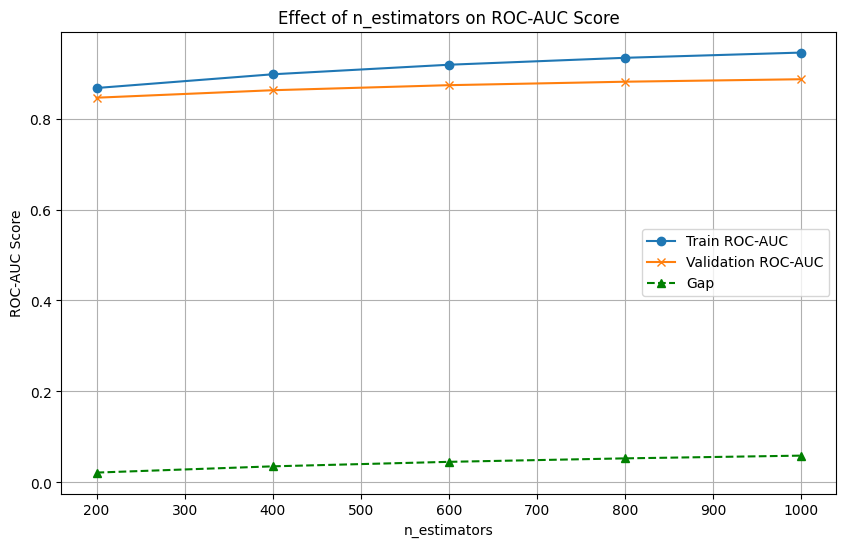

In [25]:
# Evaluate on test dataset
train_scores = []
test_scores = []
for param in train_params:
    model.set_params(**param)
    model.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovo'))
    test_score = roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo')
    test_scores.append(test_score)
train_means = train_scores

gaps = [train - test for train, test in zip(train_means, test_scores)]

# Plotting
plt.figure(figsize=(10, 6))

# Plotting training scores
plt.plot(n_estimators_values, train_means, label='Train ROC-AUC', marker='o')

# Plotting test scores
plt.plot(n_estimators_values, test_scores, label='Validation ROC-AUC', marker='x')

plt.plot(n_estimators_values, gaps, label='Gap', marker='^', linestyle='--', color='green')


plt.title('Effect of n_estimators on ROC-AUC Score')
plt.xlabel('n_estimators')
plt.ylabel('ROC-AUC Score')
plt.grid(True)
plt.legend()
plt.show()

### Final Model

In [27]:
# Initialize XGBClassifier with optimized parameters
model = XGBClassifier(n_estimators= 500,
   learning_rate= 0.1,
   max_depth= 5,
   min_child_weight= 1,
   gamma= 0,
   subsample= 0.9,
   colsample_bytree= 1.0,
   reg_alpha=1.0)

model.fit(X_train, y_train)
modelscore(model, X_train, y_train, X_test, y_test)


Model Score
0.7283
0.6496
0.913044
0.870523


### Evaluation

#### Customized Incremental Activation Score Calculation

In [ ]:
### Scoring function for participating teams :
def incr_act_top10(input_df: pd.DataFrame,
                   pred_col: str,
                   top: 10,
                   cm_key='customer',
                   treated_col='ind_recommended',
                   actual_col='activation'):
	#for correcting variable types
    input_df[[treated_col, actual_col, pred_col]] = input_df[[treated_col, actual_col, pred_col]].apply(pd.to_numeric, errors='coerce')
    input_df['rank_per_cm1'] = input_df.groupby(cm_key)[pred_col].rank(method='first', ascending=False)
    input_df = input_df.loc[input_df.rank_per_cm1 <= top,:]
    agg_df = input_df.groupby(treated_col,as_index=False).agg({actual_col:'mean'})
    agg_df.columns = [treated_col,'avg_30d_act']
    recommended_avg_30d_act = float(agg_df.loc[agg_df[treated_col]==1,'avg_30d_act'])
    not_recommended_avg_30d_act = float(agg_df.loc[agg_df[treated_col]==0,'avg_30d_act'])

    return (recommended_avg_30d_act-not_recommended_avg_30d_act)

output['predicted_score'] = model.predict_proba(X_test)

scores = []
for i in range(3, 11):
    scores.append(incr_act_top10(input_df = output, pred_col = 'predicted_score', top=i))
print(scores)

#### Classification Report

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_encoded, model.predict(X_train)))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.75      0.82     42291
           1       0.76      0.43      0.55     42291
           2       0.84      0.66      0.74     42291
           3       0.70      0.60      0.65     42291

   micro avg       0.80      0.61      0.69    169164
   macro avg       0.80      0.61      0.69    169164
weighted avg       0.80      0.61      0.69    169164
 samples avg       0.60      0.61      0.60    169164



/Users/choiwonjae/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Confusion Matrix

[[40533   119  1550    89]
 [14289 18131  1274  8597]
 [14595   427 26648   621]
 [11715  5252  1303 24021]]


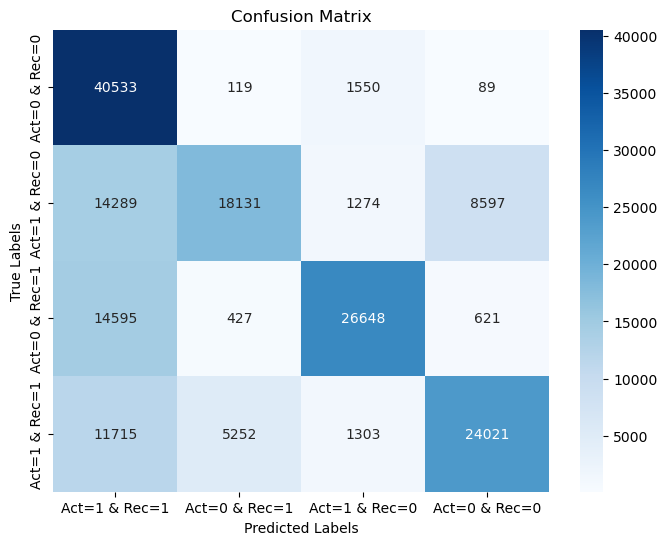

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Build confusion matrix
cm = confusion_matrix(y_train, output['predicted_score'])
print(cm)
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['Act=1 & Rec=1',
                                                                'Act=0 & Rec=1',
                                                                'Act=1 & Rec=0',
                                                                'Act=0 & Rec=0'],
            yticklabels=['Act=0 & Rec=0', 'Act=1 & Rec=0', 'Act=0 & Rec=1', 'Act=1 & Rec=1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()